In [8]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
from util import my_windowing, plot_signal, plot_log_magnitude

%matplotlib widget
plt.close("all")

file = "Audio/female8khz.wav"

Sampling Rate: 8000 Hz


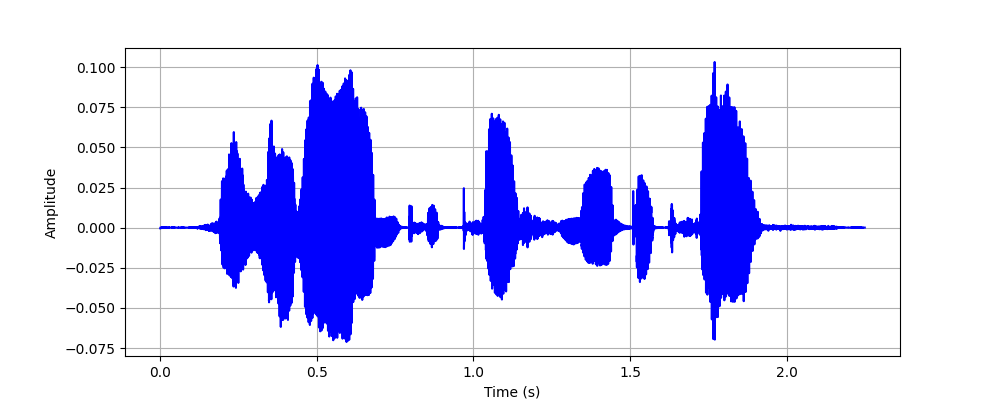

In [9]:
y, sr = librosa.load(file, sr=None)
print(f"Sampling Rate: {sr} Hz")

plot_signal(y, sr)

**2.1 Segmentation**

Before we start to analyze the speech signal, we first split the signal into overlapping segments with a length of N samples. Each segment overlaps with the previous frame by $L = N−R$ samples, like depicted in Fig. 1. Use a segment length of 32 ms and a segment shift of 8 ms. You may use the function `m_frames, v_time_frame = my_windowing(x, fs, N, R)` from the first exercise session.

- Why do we segment the signal prior to analysis instead of processing the whole signal at once?
- Is a segment length of 32 ms appropriate? Why or why not?

In [10]:
m_frames, v_time = my_windowing(y, sr, 32, 8)

**2.2 Signal power**

In the following, we want to estimate a set of parameters for each of the segments. We begin with creating a function named compute_power that takes a signal segment as an input variable and returns the signal power,

where n is the sample index and x(n) corresponds to the current signal segment. Compute the signal power for each segment and store it in a vector. Display the standard deviation (√σ2x = σx) together with the waveform of the speech signal in one plot.

In [13]:
def compute_power(seg: np.ndarray) -> float:
    power: float = 0
    for sample in seg:
        power += sample ** 2
    
    return (1/len(seg)) * power

v_power = np.zeros()
    

6.260816007852554e-07
